# A model of learning of the income process

This notebook experiments multiple dimensions via which agents misspecify the model of income leading to following empirical patterns of subjective income risk

- Higher realizations corresponding to lower perceived risks 
- Older age corresponds to lower uncertainty 
- Cohort-specific uncertainty depending on the past realization of the income dispersion of the group 
- Asymmetry in the effect of realization of shocks, i.e. positive shocks brings about lower uncertainty and higher reduces the uncerainty. 
- Interplay between income realizations and uncertainty, i.e. extrapolative from the first moment to the second 

### Income process and baseline model of learning  

We start by defining an AR(1) process of the individual income. In particular, the income of individual $i$ from the cohort $c$ at time $t$ depends on her previous-period income with a persistence parameter of $\rho$ and an individual and time-specific shock $\epsilon_{i,c,t}$. 

\begin{eqnarray}
y_{i,c,t} = \rho y_{i,c,t-1} + \epsilon_{i,c,t}
\end{eqnarray}

In this paper, I define cohort $c$ to be measured by the year of entry in job market. It is assumed the persistence parameter is the same across all inviduals at each point of the time. Also, I assume the income shock $\epsilon_{i,c,t}$ to be purely i.i.d., namely independent across individuals and time and with an identical variance, as defined in the equation below. (Later sections will relax this assumption by allowing for cross-ectional correlation or aggregate risks.)

\begin{eqnarray}
E(\epsilon_{t}'\epsilon_{t}|Y_{t-1}) = \sigma^2 I_n \quad \forall t 
\end{eqnarray}

where $\sigma^2$ is the volatility of income shock and $I_n$ is an identity matrix whose length is the number of agents in the economy, $n$. Although income volatility is not cohort-specific, the impacts of the same shock still differ for different cohorts as they have gone through different spells of history. This is reminiscent of <cite data-cite="bansal2004risks">Storesletten et al. (2004)</cite>. Since both $\rho$ and $\sigma^2$ are not cohort-specific, I drop the subscript $c$ from now on to avoid clustering. 

Both $\rho$ and $\sigma^2$ are known by modelers, but unknown by agents in the economy. Individual $i$ learns about the income process by ``running'' a regression based on the model above using a limited sample from her past experience since her entrance of the market till that point of the time. Critically, for this paper's purpose,  I allow the experience used for learning to be include both her own past income and others' over the same period. It is admittedly bizarre to assume individual agents have access to the whole population's income. A more realistic assumption could be that only a small cross-sectional sample is available to the agent. Any scope of cross-sectional social learning suffices for the point to be made in this paper.  


In [124]:
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_process import ArmaProcess
import numpy.linalg as lg
from scipy.special import erf 
import pandas as pd
from numba import njit

In [126]:
class ARProcess:
    def __init__(self,
                 ar_paras = np.array([0.97,0.4]),
                 N = 60):
        self.ar_paras = ar_paras
        self.rho = ar_paras[0]
        self.sigma = ar_paras[1]
        self.N = N 
        self.k = 1
        self.burn = 0.1
        self.n_sim = 30
        self.shock_type = 'iid'
        self.shock_type_perceived = 'iid'
        self.work_age = 15
        self.agg_corr = 1
        self.corr = 0.9
        self.theta = 1.5
             
# simulate individual time series and cross-sectional data 

    def Simulateiid(self):
        ar1 = self.ar_paras
        rho,sigma = ar1
        ma1 = np.array([1])
        N_burn = int(self.burn*self.N)
        N_long = self.N + N_burn
        simulated_data = np.empty(N_long)
        simulated_data[0] = 0.01
        shocks = sigma*np.random.randn(N_long)
        for i in range(N_long-1): 
            simulated_data[i+1] = rho*simulated_data[i] + shocks[i+1]
        #AR_object1 = ArmaProcess(ar1,ma1)
        #simulated_data = AR_object1.generate_sample(nsample = self.N)
        self.simulated = simulated_data[N_burn:]
        return self.simulated 
    
    def SimulateAggCorr(self):
        ar1 = self.ar_paras
        rho,sigma = ar1
        N_burn = int(self.burn*self.N)
        N_long = self.N + N_burn
        
        ## correlation matrix 
        mean = np.zeros(self.n_sim)
        cov = self.agg_corr*np.ones([self.n_sim,self.n_sim])
        np.fill_diagonal(cov,1)   ## diagnal being 1
        
        ## generate shocks that are cross-sectionally correlated 
        
        shocks = np.random.multivariate_normal(mean,cov) # for a particular t
        for t in range(N_long):
            shocks_this_t = np.random.multivariate_normal(mean,cov) # for a particular t
            shocks = np.vstack((shocks,
                                shocks_this_t))
        shocks = shocks.T
        simulated_pop = np.empty([self.n_sim,N_long])
        simulated_pop[:,0] = 0.01
        for i in range(self.n_sim):
            for t in range(N_long-1):
                simulated_pop[i,t+1] = rho*simulated_pop[i,t] + shocks[i,t+1]
        return simulated_pop[:,N_burn:]
        
    def SimulatePop(self):
        self.simulated_pop = np.empty([self.n_sim,self.N])
        if self.shock_type =='iid':
            for i in range(self.n_sim):
                self.simulated_pop[i,:] = self.Simulateiid()
        if self.shock_type =='correlated':
            self.simulated_pop = self.SimulateAggCorr()
            
        return self.simulated_pop
    
## learning based on a given sample 
    
    def LearnPara(self,
                  sample,
                  which = 1): 
        n_sim,N = sample.shape
        Y = np.asmatrix(sample[:,1:].flatten()).T
        X = np.asmatrix(sample[:,:-1].flatten()).T
        nobs = len(Y)
        model = sm.OLS(Y,X)
        rs = model.fit()
        #print(rs.summary())
        coeffs_est = rs.params
        self.rs_correct = rs
        self.errs = rs.resid.reshape(n_sim,N-1) ## residuals matrix 
        
        if self.shock_type_perceived == 'iid':
            self.sigma2_est = np.sum(self.errs**2)/(rs.nobs-1)
            self.D = np.eye(nobs)*self.sigma**2
            self.D_est = np.eye(nobs)*self.sigma2_est
            xx = np.dot(X.T,X)
            ## regression coeffs 
            #coef_var_est0 = rs.bse**2  # using statsmodel package 
            coef_var_est1 = np.array(lg.inv(xx)*self.sigma2_est)  ## by hand 
            #coef_var_est2 = np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xx),
            #                                     X.T),
            #                                     self.D_est),
            #                              X),
            #                       lg.inv(xx)
            #                      )) ## by general formula 
            self.coef_var_est = coef_var_est1
            
        if self.shock_type_perceived == 'non-independence':  ## generalized least square 
            sigma_est = np.eye(nobs)
            for i in range(int(rs.nobs - N)):
                sigma_est[i,i+N]= self.corr
                sigma_est[i+N,i] = self.corr ## create correlation across people
            #sigma_est = np.where(sigma_est == 0, 
            #                     self.corr**2, 
            #                     sigma_est)  # diagnal being 1 and off-diagnal being subjective corr
            xx = np.dot(X.T,X)
            xsx = np.array(lg.inv(np.dot(np.dot(X.T,
                                                lg.inv(sigma_est)
                                                      ),
                                                X)
                                        )
                                        )  # X'sigma^-1X
            xsy = np.array(np.dot(np.dot(X.T,
                                         lg.inv(sigma_est)
                                        ),
                                  Y) # X'sigma^-1Y
                          )
            #coeffs_est = np.dot(xsx,
            #                    xsy)   # beta_gls 
            
            #err1d = Y-X*coeffs_est
            #self.errs = err1d.reshape(n_sim,N-1)
            self.sigma2_est = np.sum(np.array(self.errs)**2)/(rs.nobs-1)
            self.D_est = sigma_est*self.sigma2_est
            coef_var_est2 = np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xx),
                                                 X.T),
                                                 self.D_est),
                                          X),
                                  lg.inv(xx)   
                                  )) ## by general formula   ## variance of ols estimate
            coef_var_est3 = np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xsx),
                                                 X.T),
                                                 self.D_est),
                                          X),
                                  lg.inv(xsx)   
                                  )) ## by general formula   ## variance of gls estimate
            self.coef_var_est = coef_var_est2
            
        if self.shock_type_perceived == 'cluster':
            self.sigma2_est = np.sum(self.errs**2)/(rs.nobs-1)
            self.D_est = np.sum([np.dot(np.matrix(np.sum(sample[:,j]*self.errs[:,j])),
                                       lg.inv(np.matrix(np.sum(sample[:,j]*self.errs[:,j]
                                                              )
                                                       )
                                             )
                                      ) for j in range(N-1)])
            xx = np.dot(X.T,X)
            ## regression coeffs 
            coef_var_est2 = (rs.nobs-1)/(rs.nobs-self.k)*N/(N-1)*np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xx),
                                                 X.T),
                                                 self.D_est),
                                          X),
                                   lg.inv(xx)
                                  )) ## by general formula 
            D_est_simple = self.sigma2_est*(1+self.corr*(N-1))
            coef_var_est3 = lg.inv(xx)*D_est_simple
            self.coef_var_est = coef_var_est3
            
        if self.shock_type_perceived == 'serial_correlate':
            self.sigma2_est = np.sum(self.errs**2)/(rs.nobs-1)
            self.D_est = np.sum([np.dot(np.matrix(np.sum(sample[i,:-1]*self.errs[i,:])),
                                       lg.inv(np.matrix(np.sum(sample[i,:-1]*self.errs[i,:]
                                                              )
                                                       )
                                             )
                                      ) for i in range(n_sim)])
            xx = np.dot(X.T,X)
            ## regression coeffs 
            coef_var_est2 = (rs.nobs-1)/(rs.nobs-self.k)*N/(N-1)*np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xx),
                                                 X.T),
                                                 self.D_est),
                                          X),
                                   lg.inv(xx)
                                  )) ## by general formula 
            self.coef_var_est = coef_var_est2
            
        if self.shock_type_perceived == 'attribution_biased':
            recent_chg = sample[which,-1] - sample[which,-2]
            if  recent_chg >= 0:  ## positive change, then i.i.d. 
                self.sigma2_est = np.sum(self.errs**2)/(rs.nobs-1)
                self.D = np.eye(nobs)*self.sigma**2
                self.D_est = np.eye(nobs)*self.sigma2_est
                xx = np.dot(X.T,X)
                ## regression coeffs 
                #coef_var_est0 = rs.bse**2  # using statsmodel package 
                coef_var_est1 = np.array(lg.inv(xx)*self.sigma2_est)  ## by hand 
                #coef_var_est2 = np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xx),
                #                                     X.T),
                #                                     self.D_est),
                #                              X),
                #                       lg.inv(xx)
                #                      )) ## by general formula 
                self.coef_var_est = coef_var_est1
            elif recent_chg < 0:
                self.sigma2_est = np.sum(self.errs**2)/(rs.nobs-1)
                self.D_est = np.sum([np.dot(np.matrix(np.sum(sample[:,j]*self.errs[:,j])),
                                           lg.inv(np.matrix(np.sum(sample[:,j]*self.errs[:,j]
                                                                  )
                                                           )
                                                 )
                                          ) for j in range(N-1)])  ## hat omega = sum_g (sum_ng x e)(sum_ng x e)'
                xx = np.dot(X.T,X)
                ## regression coeffs 
                coef_var_est2 = (rs.nobs-1)/(rs.nobs-self.k)*N/(N-1)*np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xx),
                                                     X.T),
                                                     self.D_est),
                                              X),
                                       lg.inv(xx)
                                      )) ## by general formula
                D_est_simple = self.sigma2_est*(1+self.corr*(N-1))
                coef_var_est3 = lg.inv(xx)*D_est_simple
                
                self.coef_var_est = coef_var_est3  ## negative changes, then cluster 
        
        if self.shock_type_perceived == 'extrapolative_attribution_biased':
            recent_chg = sample[which,-1] - sample[which,-2]
            corr = self.extrapolate(recent_chg)
            self.sigma2_est = np.sum(self.errs**2)/(rs.nobs-1)
            xx = np.dot(X.T,X)
            ## regression coeffs 
            D_est_simple = self.sigma2_est*(1+corr*(N-1))
            coef_var_est3 = lg.inv(xx)*D_est_simple    
            self.coef_var_est = coef_var_est3  ## based on the extrapolative corr            
        
        if self.shock_type_perceived == 'attribution_biased2':
            recent_chg = sample[which,-1] - sample[which,-2]
            if  recent_chg >= 0:  ## positive change, then i.i.d. 
                self.sigma2_est = np.sum(self.errs**2)/(rs.nobs-1)
                self.D = np.eye(nobs)*self.sigma**2
                self.D_est = np.eye(nobs)*self.sigma2_est
                xx = np.dot(X.T,X)
                ## regression coeffs 
                #coef_var_est0 = rs.bse**2  # using statsmodel package 
                coef_var_est1 = np.array(lg.inv(xx)*self.sigma2_est)  ## by hand 
                #coef_var_est2 = np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xx),
                #                                     X.T),
                #                                     self.D_est),
                #                              X),
                #                       lg.inv(xx)
                #                      )) ## by general formula 
                self.coef_var_est = coef_var_est1
            elif recent_chg < 0:
                sigma_est = np.eye(nobs)
                for i in range(int(rs.nobs - N)):
                    sigma_est[i,i+N]= self.corr**2
                    sigma_est[i+N,i] = self.corr**2 ## create correlation across people
                #sigma_est = np.where(sigma_est == 0, 
                #                     self.corr**2, 
                #                     sigma_est)  # diagnal being 1 and off-diagnal being subjective corr
                xx = np.dot(X.T,X)
                xsx = np.array(lg.inv(np.dot(np.dot(X.T,
                                                    lg.inv(sigma_est)
                                                          ),
                                                    X)
                                            )
                                            )  # X'sigma^-1X
                xsy = np.array(np.dot(np.dot(X.T,
                                             lg.inv(sigma_est)
                                            ),
                                      Y) # X'sigma^-1Y
                              )
                #coeffs_est = np.dot(xsx,
                #                    xsy)   # beta_gls 

                #err1d = Y-X*coeffs_est
                #self.errs = err1d.reshape(n_sim,N-1)
                self.sigma2_est = np.sum(np.array(self.errs)**2)/(rs.nobs-1)
                self.D_est = sigma_est*self.sigma2_est
                coef_var_est2 = np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xx),
                                                     X.T),
                                                     self.D_est),
                                              X),
                                      lg.inv(xx)   
                                      )) ## by general formula   ## variance of ols estimate
                coef_var_est3 = np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xsx),
                                                     X.T),
                                                     self.D_est),
                                              X),
                                      lg.inv(xsx)   
                                      )) ## by general formula   ## variance of gls estimate
                self.coef_var_est = coef_var_est2
        ## common estimate 
        self.paras_learned = coeffs_est
        
        ## forecast 
        self.var_predict_chg = self.sigma**2
        self.var_predict_chg_est = self.sigma2_est + sample[which,-1]**2*self.coef_var_est 
        # n_sim individual-specific var
        return self.paras_learned,self.coef_var_est,self.sigma2_est
    
## ages and experiences 

    def SimulateAgePop(self):
        minus_life = np.flip(np.arange(self.N))
        minus_life = np.expand_dims(minus_life,
                                    axis = 1).T
        minus_life_pop_sim = np.repeat(minus_life,
                                       self.n_sim,
                                       axis = 0) ## a matrix that is to be substracted to get the ages
        #age_pop_last = np.arange(self.n_sim)+20
        np.random.seed(23023)
        age_pop_last = np.random.choice(range(20,60),
                                        self.n_sim)
        age_pop_last = np.expand_dims(age_pop_last,
                                      axis =1) # a population with different ages 
        self.ages_pop_sim = age_pop_last - minus_life_pop_sim ## get the age 
        self.ages_pop_sim = np.where(self.ages_pop_sim < self.work_age, np.nan, self.ages_pop_sim)         
        return self.ages_pop_sim
    
    def Experience(self): ## age_pop is a simulated matrix with people in different ages. 
        sparse_pop = np.zeros(self.n_sim,self.N)
        for i in range(self.n_sim):
            for j in range(self.N):
                if j>=self.N-self.ages_pop_sim[i]:
                    sparse_pop[i,j] = 1 
    
    def LearnParafromExperience(self):
        
        ## simulate age 
        self.SimulateAgePop()
        
        ## locations 
        coeffs_est = np.empty([self.n_sim,self.N])
        sigma2_est = np.empty([self.n_sim,self.N])
        coef_vars_est = np.empty([self.n_sim,self.N])
        var_predict_chg_est = np.empty([self.n_sim,self.N])
        av_past = np.empty([self.n_sim,self.N])
        
        for i in range(self.n_sim):
            for j in range(self.N):
                if self.ages_pop_sim[i,j] > self.work_age:
                    st = np.min([idx for idx in range(j)]) ## begin of experience
                    ed = j  ## end of experience
                    sample_this = self.simulated_pop[:,st:ed]
                    if sample_this.shape[1] >= 2:  ## at least two observations 
                        self.LearnPara(sample = sample_this,
                                       which = i)
                        coeffs_est[i,j] = self.paras_learned
                        sigma2_est[i,j] = self.sigma2_est
                        coef_vars_est[i,j] = self.coef_var_est
                        var_predict_chg_est[i,j] = self.var_predict_chg_est
                        av_past[i,j] = np.mean(sample_this[i,:])
                else:
                    coeffs_est[i,j] =  np.nan
                    sigma2_est[i,j] = np.nan
                    coef_vars_est[i,j] = np.nan
                    var_predict_chg_est[i,j] = np.nan
                    av_past[i,j] = np.nan
                    
        self.coeffs_est = coeffs_est
        self.sigma2s_est = sigma2_est
        self.coef_vars_est = coef_vars_est
        self.var_predict_chg_est = var_predict_chg_est
        self.av_past = av_past 
        
        return self.coeffs_est,self.coef_vars_est,self.sigma2s_est,self.var_predict_chg_est
    
## other functions
    def logisticfunc(self,
                     x):
        return 1/(1+np.exp(-self.theta*x))
    
    def extrapolate(self,
                    shock,
                    how = 'by_size'):
        if how =='by_size':
            corr = 1-self.logisticfunc(shock)
        elif how =='by_sign':
            corr = np.array(shock < 0)  ## 0 or 1 depending on the sign 
        return corr
    
    def extrapolate2(self,
                   shock,
                   how = 'by_size'):
        if how =='by_size':
            corr = -erf(self.theta*shock)
        elif how =='by_sign':
            corr = np.array(shock < 0)  ## 0 or 1 depending on the sign 
        return corr

In [127]:
## initialize an instance 

one = ARProcess()
simulated_data1 = one.Simulateiid()

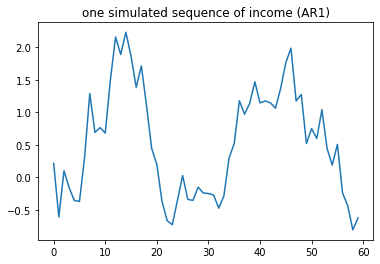

In [128]:
## simulate ar1 data 

plt.subplot(1,1,1)
plt.title('one simulated sequence of income (AR1)')
plt.plot(simulated_data1)

Text(0.5, 1.0, 'Distribution of income over time')

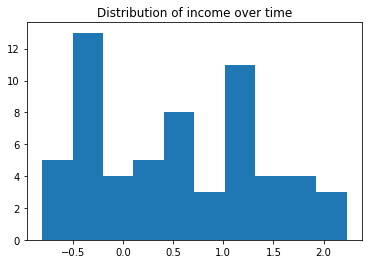

In [129]:
dist = plt.hist(simulated_data1)
plt.title('Distribution of income over time')

In [130]:
one.n_sim = 60
simulated_data_pop = one.SimulatePop()

Text(0.5, 1.0, 'Unconditional distribution')

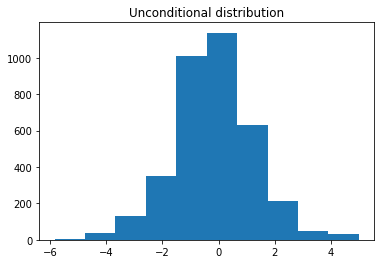

In [131]:
dist_pop = plt.hist(simulated_data_pop.flatten())
plt.title('Unconditional distribution')

### A baseline model of experience-based learning

Assuming each agent knows perfectly the model parameters $\rho$ and $\sigma$, the uncertainty about future income growth is 

\begin{eqnarray}
\begin{split}
Var^*_{i,t}(\Delta y_{i,t+1}) & =  Var^*_{i,t}(y_{i,t+1}- y_{i,t}) \\ 
& =  Var^*_{i,t}(\rho-1)y_{i,t} + \epsilon_{i,t+1}) \\
& = Var^*_{i,t}(\epsilon_{i,t+1}) \\
& = \sigma^2
\end{split}
\end{eqnarray}

The superscript $*$ is the notation for perfect understanding. 

Under imperfect understanding and learning, both $\rho$ and $\sigma^2$ are unknown to agents. Therefore, the agent needs to learn about the parameters from the small panel sample experienced up to that point of the time. We represent the sample estimates of $\rho$ and $\sigma^2$ using $\widehat \rho$ and $\hat{\sigma}^2$. 

\begin{eqnarray}
\begin{split}
Var_{i,t}(\Delta y_{i,t+1}) & = y_{i,t-1}^2 \widehat{Var}^{\rho}_{i,t} + \hat{\sigma}^2_{i,t}
\end{split}
\end{eqnarray}

The perceived risks of future income growth have two components. The first one comes from the uncertainty about the persistence parameter. The second is based on the estimated risk of a yet-unrealized shock. The first component is non-existent under perfect understanding. Notice that this source of uncertainty is scaled by the squared size of the contemporary income. It implies that the income risks are size-dependent under imperfect understanding. And the second component has its perfectly known counterpart under perfect understanding. In general, the estimates $\hat{\sigma}^2_{i,t}$ can be lower or higher than the true risks.  

We assume the agents learn the parameters using the least square rule. We also assume that in the true model the shock is i.i.d, namely it is independent across different earners and different periods of time. 


\begin{eqnarray}
\hat \rho_{i,ols} = (Y_{t-1}'Y_{t-1})^{-1}(Y_{t-1}Y_{t})
\end{eqnarray}


\begin{eqnarray}
\widehat{\sigma}^2_{i,ols} = s^2 = \frac{1}{N-1} \sum \hat e_i^2
\end{eqnarray}

where $N$ is the size of the panel sample available to the agent $i$.

Under i.i.d. assumption, the estimated uncertainty about the estimate is 

\begin{eqnarray}
\widehat {Var}^{\rho}_{i,t} = (Y_{t-1}'Y_{t-1})^{-1}\widehat{\sigma}^2_{i,ols}I_N
\end{eqnarray}

Experience-based learning naturally introduces a mechanism for the perceived income risks to be cohort-specific and age-specific. Different generations who have experienced different realizations of the income shocks have different estimates of $\rho$ and $\sigma^2$, thus different in their uncertainty about future income. In the meantime, people at an older age are faced with a larger sample size than younger ones, this will drive the age profile of perceived risks in line with the observation that the perceived risk is lower as one grows older. 

### Attribution bias 

The attribution bias induces an agent to subjectively make assumptions about the cross-sectional correlation of shocks, which may or may not be consistent with the truth. The particular manifesto of the bias, as far as this paper is concerned, is that people attribute bad luck to external causes and good luck to internal ones. The learning framework can neatly capture this by assuming that people's subjective specification of the nature of the shocks $\epsilon$ asymmetrically depends on the sign of the recent income change (or the realized shocks). More formally, I use superscript $\tilde{}$ to denote perceptions under attribution bias, the bias can manifest itself in the following way. 

\begin{eqnarray}
\begin{split}
\tilde E_{i,t}(\epsilon_{i,t},\epsilon_{j,t}|Y_{t-1}) = 0 \quad \textrm{if} \quad \Delta(y_{i,t})>0 \\
\tilde E_{i,t}(\epsilon_{i,t},\epsilon_{j,t}|Y_{t-1}) > 0 \quad \textrm{if} \quad \Delta(y_{i,t})<0
\end{split}
\end{eqnarray}


This implies, a positive change in income induces the agent to maintain the independence assumption of the shocks, while a negative change in income makes the agent interpret the shock to be positively correlated with each other within each point of the time. Assuming the perceived correlation is the same between different people, this is equivalent to saying that the agent's subject attribution leads her to believe that the correlation across agents is $\tilde\delta_{i,t}$. 


\begin{eqnarray}
\begin{split}
\tilde\delta_{i,t} = 0 \quad \textrm{if} \quad \Delta(y_{i,t})>0 \\
\tilde\delta_{i,t} = 1 \quad \textrm{if} \quad \Delta(y_{i,t})<0
\end{split}
\end{eqnarray}

The agent still adopts the ordinary least square learning rule. Therefore, her estimate of $\rho$ remains the same as before. However, the uncertainty about the estimate of $\rho$ is no longer the same because of the attribution bias. Econometrically, this is equivalent to accounting for clustered standard errors across observations within each point of time. If we maintain the homoscedasticity assumption, i.e. income risks do not change over time $\sigma$, one can derive the uncertainty about the persistence parameter as below 

\begin{eqnarray}
\begin{split}
\tilde {Var}^{\rho}_{i,t}  = (Y_{t-1}'Y_{t-1})^{-1}\widehat{\sigma}^2(1+ \tilde\delta_{i,t}(n-1))
\end{split}
\end{eqnarray}

Where $n$ is the number of observations within each time cluster, i.e. the number of people at any point of the time.

One can show immediately the following:

\begin{eqnarray}
\tilde {Var}^{\rho}_{i,t} \geq \widehat {Var}^{\rho}_{i,t} \quad \forall \quad \tilde\delta_{i,t} \geq 0
\end{eqnarray}

where the equality holds as a special case when $\tilde\delta_{i,t} = 0$. The left hand side monotonically increases with $\tilde \delta_{i,t}$. 

In the meantime, the estimates of $\sigma^2$ remain the same no matter if the attribution bias arises, both of which are equal to the sample average of regression residuals $s^2$. 


\begin{eqnarray}
\tilde{\sigma}^2_{i,t} = \widehat{\sigma}^2_{i,t}
\end{eqnarray}

Combining both relations above, one can show the perceived risks of an unlucky person is unambiguously higher than that of a lucky one. 

\begin{eqnarray}
\begin{split}
\tilde {Var}_{i,t}(\Delta y_{i,t+1}) & = y_{i,t-1}^2 \tilde{Var}^{\rho}_{i,t} + \tilde{\sigma}^2_{i,t} \\
& \geq \widehat {Var}_{i,t}(\Delta y_{i,t+1}) 
\end{split}
\end{eqnarray}

One way to rephrase the inequality above is that the unlucky group excessively extrapolates the realized shocks into her perception of risks. There is no distinction between the lucky and unlucky group in perceived risks without the attribution bias. In the presence of the bias, anyone who is unlucky to have just experienced a negative income change has a higher perceived risk compared to any lucky one. This is because of the asymmetric attribution embedded in the bias.

We have the following predictions about the perceived income risks from the analysis. 

- Higher subjective correlation $\tilde \delta_{i,t}$ leads to higher perceived risks $\tilde{var}_{i,t}$;
- Higher experienced volatility, measured by $s^2 \equiv \tilde{\sigma}^2_{i,t}$ leads to higher perceived income risks. This mechanism is shared by people with different degree of attribution bias. What's different between different attribution is that higher bias, i.e. higher $\tilde \delta_{i,t}$ induces the agent to disproprotionately extrapolate the paramter uncertainty, thus perceived risks. See the comparison between Figure \ref{var_experience_var}. This is different from the scenario without attribution bias.  

It is important to note that this difference still arises even if one assumes the underlying shocks are indeed non-independent. Although different types of income shocks have different implications as to which group correctly or mis-specifies the model, it does not alter the distinction between the lucky and unlucky group. To put it bluntly,  the underlying process determines who is over-confident or under-confident. But the lucky group is always more confident than the unlucky group. 

Text(0, 0.5, '$\\hat \\delta_{i,t}$')

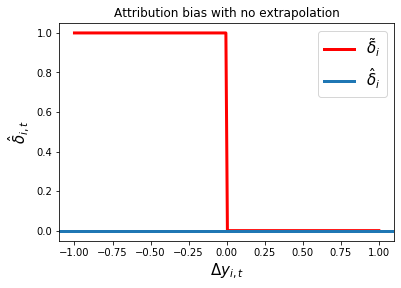

In [132]:
## simple attribution function

chgs = np.linspace(-1,1,200)
corrs = one.extrapolate(chgs,
                       how = 'by_sign')

plt.title('Attribution bias with no extrapolation')
plt.plot(chgs,
         corrs,
         'r-',
         lw = 3,
        label = r'$\tilde \delta_{i}$')
plt.axhline(0,
            lw = 3,
           label =r'$\hat \delta_{i}$')
plt.legend(loc = 0,
           fontsize = 15)
plt.xlabel(r'$\Delta y_{i,t}$',
          fontsize = 15)
plt.ylabel(r'$\hat \delta_{i,t}$',
          fontsize = 15)

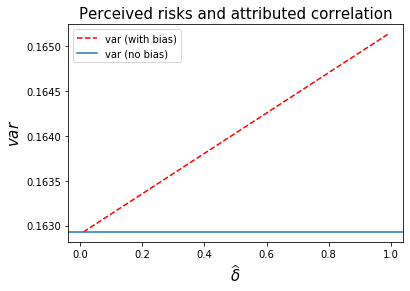

In [133]:
## different attributions and perceived income risks  

times = 10
corrs = np.linspace(0.01,0.99,times)
vars_predict_est = np.empty(times)

for i,corr in enumerate(corrs):
    one.corr = corr
    one.Simulateiid()
    one.shock_type_perceived = 'attribution_biased'
    one.LearnPara(sample = one.simulated_pop,
                 which = 2)
    vars_predict_est[i] = one.var_predict_chg_est

plt.plot(corrs,
        vars_predict_est,
        'r--',
        label = "var (with bias)")
plt.axhline(vars_predict_est[0],
            label = 'var (no bias)')
plt.title('Perceived risks and attributed correlation',
         fontsize = 15)
plt.xlabel(r'$\widehat\delta$',
          fontsize = 15)
plt.ylabel(r'$var$',
          fontsize = 15)
plt.legend(loc = 0)

### Extrapolative attribution bias

The baseline model only lets the sign of the recent income change induce attribution bias, and assumes away the possibility of the attribution bias to depend on the magnitude of the recent changes endogenously. This is reflected in the model assumption that $\tilde \delta_i$ could take either 1 or 0 depending on the sign of the recent income change. We could alternatively allow the attributed correlation $\tilde \delta_i$ to be a function of the $\Delta(y_{i,t})$. This will open the room for income changes of different salience to induce different degrees of attribution bias. 

In order to capture this size-dependent pattern, I choose an attribution function that takes the following form as the following. It does not have to be this function in particular, but its properties suit the purpose here.   

\begin{eqnarray}
\begin{split}
\tilde \delta(\Delta y_{i,t}) = 1- \frac{1}{(1+e^{-\theta \Delta y_{i,t}})}
\end{split}
\end{eqnarray}


Basically, the attribution function is a continuous variant of the logistic function with its function value bounded between $[0,1]$. It takes a s-shape and the parameter $\theta$ governs the steepness of the s-shape around its input value. In the model, $\theta$ is the parameter that governs the degree of the attribution bias. It takes any non-negative value. Although the quanlitative pattern induced by the attribution bias stands for any positive $\theta$, letting it to be a parameter leaves modelers the room to recover it from subjective risks data. The attribution function under different $\theta$ is shown in Figure \ref{attribution_func_size}. The higher $\theta$ is, the more sensitive the assigned correlation is to the size of the shock, thus inducing a higher dispersion of the perceived correaltion between the lucky group and unlucky group. 

Text(0.5, 1.0, 'Attribution function with different degrees of bias')

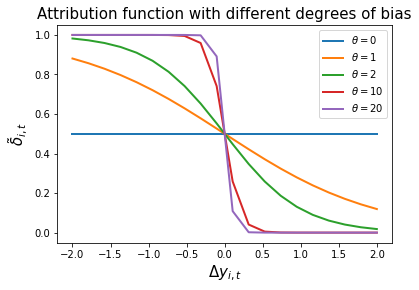

In [134]:
## extrapolative attribution function

chgs = np.linspace(-2,2,20)

thetas = np.array([0,1,2,10,20])

for theta in thetas:
    one.theta = theta
    corrs = one.extrapolate(chgs)
    plt.plot(chgs,
             corrs,
             lw = 2,
             label = r'$\theta =$'+str(theta))
    #plt.axhline(0,
    #           label =r'$\hat \delta_{i}$')
    plt.legend(loc = 0,
              fontsize = 10)
plt.xlabel(r'$\Delta y_{i,t}$',
           fontsize = 15)
plt.ylabel(r'$\tilde \delta_{i,t}$',
           fontsize = 15)
plt.title('Attribution function with different degrees of bias',
         fontsize = 15)

In [135]:
## for iid
## Estimate the model with the correctly specified model of i.i.d shock
one.shock_type_perceived = 'iid'
coeffs_est_iid,coef_vars_est_iid,sigma2s_est_iid,var_predict_chg_est_iid = one.LearnParafromExperience()
var_predict_chg_est_iid_mean = np.nanmean(var_predict_chg_est_iid)

est_iid = {'coef_est':np.nanmean(coeffs_est_iid),
          'coef_var_est':np.nanmean(coef_vars_est_iid),
          'sigma2s_est':np.nanmean(sigma2s_est_iid),
          'var_predict_chg_est':np.nanmean(var_predict_chg_est_iid)}

## for cluster 
one.shock_type_perceived = 'cluster'
coeffs_est_cl,coef_vars_est_cl,sigma2s_est_cl,var_predict_chg_est_cl = one.LearnParafromExperience()


est_cl = {'coef_est':np.nanmean(coeffs_est_cl),
          'coef_var_est':np.nanmean(coef_vars_est_cl),
          'sigma2s_est':np.nanmean(sigma2s_est_cl),
          'var_predict_chg_est':np.nanmean(var_predict_chg_est_cl)}

## for serial_correlate 
one.shock_type_perceived = 'serial_correlate'
coeffs_est_sc,coef_vars_est_sc,sigma2s_est_sc,var_predict_chg_est_sc = one.LearnParafromExperience()

est_sc = {'coef_est':np.nanmean(coeffs_est_sc),
          'coef_var_est':np.nanmean(coef_vars_est_sc),
          'sigma2s_est':np.nanmean(sigma2s_est_sc),
          'var_predict_chg_est':np.nanmean(var_predict_chg_est_sc)}

## for attribution biased

one.shock_type_perceived = 'attribution_biased'
coeffs_est_ab,coef_vars_est_ab,sigma2s_est_ab,var_predict_chg_est_ab = one.LearnParafromExperience()

est_ab = {'coef_est':np.nanmean(coeffs_est_ab),
          'coef_var_est':np.nanmean(coef_vars_est_ab),
          'sigma2s_est':np.nanmean(sigma2s_est_ab),
          'var_predict_chg_est':np.nanmean(var_predict_chg_est_ab)}


## for attribution biased by size 

one.shock_type_perceived = 'extrapolative_attribution_biased'
coeffs_est_eab,coef_vars_est_eab,sigma2s_est_eab,var_predict_chg_est_eab = one.LearnParafromExperience()

est_eab = {'coef_est':np.nanmean(coeffs_est_eab),
          'coef_var_est':np.nanmean(coef_vars_est_eab),
          'sigma2s_est':np.nanmean(sigma2s_est_eab),
          'var_predict_chg_est':np.nanmean(var_predict_chg_est_eab)}

idx = ['iid','cluster','serial correlation','attribution biased','ex_attribution biased']

ests = pd.DataFrame.from_dict([est_iid, 
                               est_cl,
                               est_sc,
                               est_ab,
                              est_eab])
ests.index = idx

In [136]:
ests

,coef_est,coef_var_est,sigma2s_est,var_predict_chg_est
iid,0.966342,0.000038,0.162626,0.162704
cluster,0.966342,0.001501,0.162626,0.165999
serial correlation,0.966342,0.014232,0.162626,0.192203
attribution biased,0.966342,0.000760,0.162626,0.164382
ex_attribution biased,0.966342,0.000769,0.162626,0.164393


### Experienced volatility and perceived risk

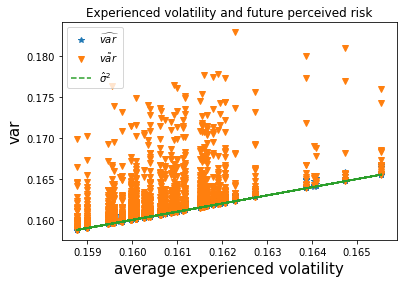

In [13]:
## simulate a historical sample populated by agents at different age 

## attribution bias 
one.shock_type_perceived = 'iid' #extrapolative_attribution_biased
coeffs_est_iid,coef_vars_est_iid,sigma2s_est_iid,var_predict_chg_est_iid = one.LearnParafromExperience()

ages = one.ages_pop_sim.flatten()
sigma2s = sigma2s_est_iid.flatten()
coef_vars_iid = coef_vars_est_iid.flatten()
vars_predict_chg_iid = var_predict_chg_est_iid.flatten()
av_past = one.av_past.flatten()

## attribution bias 

one.theta = 2
one.shock_type_perceived = 'extrapolative_attribution_biased' #extrapolative_attribution_biased
coeffs_est_ab,coef_vars_est_ab,sigma2s_est_ab,var_predict_chg_est_ab = one.LearnParafromExperience()
vars_predict_chg_ab = var_predict_chg_est_ab.flatten()
coef_vars_est_ab = coef_vars_est_ab.flatten()


## average experienced volatility and the perceived income risk

plt.plot(sigma2s,
         vars_predict_chg_iid,'*',
         label = r'$\widehat{var}$')

plt.plot(sigma2s,
         vars_predict_chg_ab,'v',
         label = r'$\tilde{var}$')

plt.plot(sigma2s,
         sigma2s,'--',
         label = r'$\hat \sigma^2$')

#plt.axhline(one.var_predict_chg,
#            color ='red',
#            label =r'$\sigma^2$')

plt.title('Experienced volatility and future perceived risk')
plt.xlabel('average experienced volatility',
           fontsize = 15)
plt.ylabel('var',fontsize = 15)
plt.legend(loc = 0)

The figure illustrates the correlation between individual's experienced volatility and future perceived income risks. Blue stars represent the scenario without attribution bias, while the orange dots represent perceived risks under attribution bias. 

We can see individuals that have had bad income realizations extrapolate the average size of past shocks into future income risks, even though the past income shocks are the best estimate of future income risks according to the underlying model. 

### Income realization and perceived risks 

Another pattern emerging as a consequence of the attribution bias is that perceived risks differ among people with different past income levels. This is not the case without attribution bias when people assess their future income risks independent from past realizations of the income changes. In order to see this, denote $\bar y_{i,c,t}$ as the average past income of the individual. 


\begin{eqnarray}
\begin{split}
\bar y_{i,c,t} & = \frac{\sum^{t-c}_{k=0}{y_{i,c,c+k}}}{t-c} \\
& = \frac{(1+\rho+...+\rho^{t-c})y_{i,c,c}}{{t-c}}+ \frac{\sum^{t-c}_{k=0}{\epsilon_{i,c,c+k}}}{{t-c}}
\end{split}
\end{eqnarray}

where, we coveniently use $c$ to denote the time of entry in job market the agent $i$. So average past income is the summation of income from $y_{i,c,c}$ up till $y_{i,c,t}$  


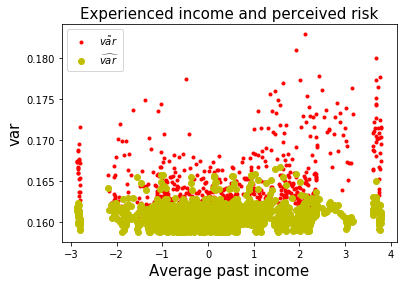

In [14]:
plt.plot(av_past,
         vars_predict_chg_ab,'r.',
         label = r'$\tilde{var}$')
plt.plot(av_past,
         vars_predict_chg_iid,'yo',
         label = r'$\widehat{var}$')
plt.title('Experienced income and perceived risk',
         fontsize = 15)
plt.xlabel('Average past income',
           fontsize = 15)
plt.ylabel('var',fontsize = 15)
plt.legend(loc = 0)

### Age and perceived risks

In [15]:
#plt.plot(one.ages_pop_sim[:,35],
#         var_predict_chg_est1[:,35],'*')
#plt.title('Perceived risks by age at a given time')
#plt.xlabel('age',fontsize = 15)
#plt.ylabel('var',fontsize = 15)

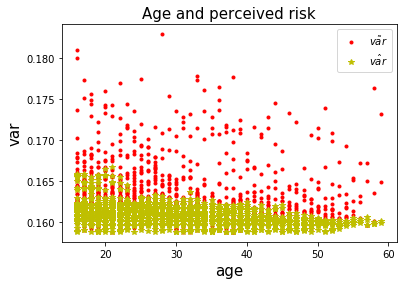

In [16]:
plt.plot(ages,vars_predict_chg_ab,
         'r.',
        label =r'$\tilde{var}$')
plt.plot(ages,vars_predict_chg_iid,
         'y*',
        label =r'$\hat{var}$')
plt.title('Age and perceived risk',
         fontsize = 15)
plt.xlabel('age',fontsize = 15)
plt.ylabel('var',fontsize = 15)
plt.legend(loc = 0)

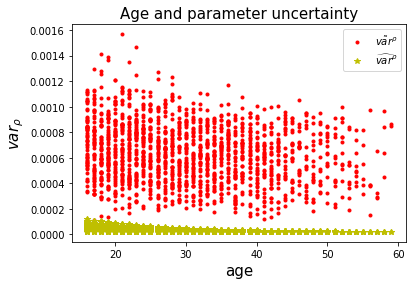

In [17]:
plt.plot(ages,
         coef_vars_est_ab,
         'r.',
        label = r'$\tilde{var}^{\rho}$')
plt.plot(ages,
         coef_vars_iid,
         'y*',
         label = r'$\widehat{var}^{\rho}$')
plt.title('Age and parameter uncertainty',
         fontsize = 15)
plt.xlabel('age',fontsize = 15)
plt.ylabel(r'$var_\rho$',fontsize = 15)
plt.legend(loc = 0)

In [18]:
#plt.plot(ages,sigma2s,'*')
#plt.xlabel('age',fontsize = 15)
#plt.ylabel(r'$\hat \sigma^2$',fontsize = 15)

## Aggregate risks

Previously, I assume the underlying shock is i.i.d. This section considers the implication of the attribution bias in the presence of both aggregate and idiosyncratic risks. This can be modeled by assuming that the shocks to individuals' income are positively correlated with each other at each point of the time. Denoting $\delta>0$ as the true cross-sectional correlation of income shocks, the conditional variance-covariance of income shocks within each period is the following. 


\begin{eqnarray}
\begin{split}
E(\epsilon_{t}'\epsilon_{t}|Y_{t-1}) = \Sigma^2 = \sigma^2\Omega \quad \forall t  
\end{split}
\end{eqnarray}

where $\Omega$ takes one in its diagonal and $\delta$ in off-diagonal.  

The learning process and the attribution bias all stay the same as before. Individuals specify their subjective structure of the shocks depending on the sign and size of their own experienced income changes. By the same mechanism elaborated above, a lucky person has lower perceived risks than her unlucky peer at any point of the time. This distinction between the two group stays the same even if the underlying income shocks are indeed correlated. 

What's new in the presence of aggregate risks lies in the behaviors of average perceived risks. Since now there is an aggregate shock that drives the comovement of the income shocks affecting individuals. Compared to the environment with pure idiosyncratic risks, there is no longer an approximately equal fraction of lucky and unlucky agents at any point of the time. Instead, the relative fraction of each group depends on the recently realized aggregate shock. If the aggregate shock is positive, more people experienced good luck and may, therefore, underestimate the correlation (a smaller $\tilde \delta$. This drives down the average perceived income risks among the population. If the aggregate shock is negative, more people experienced income decrease thus arriving at a higher perceived income uncertainty. 

This naturally leads to a counter-cyclical pattern of the average perceived risks in the economy. The interplay of aggregate risks and attribution bias adds cyclical movements of the average perceived risks. The two conditions are both necessary to generate this pattern. Without the aggregate risk, both income shocks and perceived income shocks are purely idiosyncratic and they are averaged out in the aggregate level. Without attribution bias, agents symmetrically process experiences when forming future risk perceptions.

Figure \ref{average_chg_var_agg} illustrates the first point. The scatter plots showcase the correlation between average income changes across population and average perceive risks under purely idiosyncratic risks and aggregate risks. The negative correlation with aggregate risks illustrate the counter-cylical perceived risks. There is no such a correlation under purely idiosyncratic risks. Figure \ref{average_chg_var_ab} testifies the second point. It plots the same correlation with and without attribution bias when the aggregate risk exists. Attribution bias brings about the asymmetry not seen when the bias is absent. 

In [ ]:
## plot average past income chagnes and perceived risks with aggregate risks

one.shock_type = 'correlated'  ## reset the true model to be with aggregate the risks
one.agg_corr = 1
one.SimulatePop()


one.shock_type_perceived = 'iid' #extrapolative_attribution_biased
coeffs_est_iid_ag,coef_vars_est_iid_ag,sigma2s_est_iid_ag,var_predict_chg_est_iid_ag = one.LearnParafromExperience()

one.shock_type_perceived = 'extrapolative_attribution_biased' #extrapolative_attribution_biased
coeffs_est_eab_ag,coef_vars_est_eab_ag,sigma2s_est_eab_ag,var_predict_chg_est_eab_ag = one.LearnParafromExperience()


## plot between average income change and perceived income risks cross-sectionally 

plt.plot(av_past,
         vars_predict_chg_ab,'r.',
         label = r'$\tilde{var}$')
plt.plot(av_past,
         vars_predict_chg_iid,'yo',
         label = r'$\widehat{var}$')
plt.title('Experienced income and perceived risk',
         fontsize = 15)
plt.xlabel('Average past income',
           fontsize = 15)
plt.ylabel('var',fontsize = 15)
plt.legend(loc = 0)
